In [285]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import warnings
import tensorflow as tf
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, config
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)
config.THREADING_LAYER = 'threadsafe'

from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
from sklearn.cluster import DBSCAN

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = set(ENGLISH_STOP_WORDS)
stop_words.add('said')
ENGLISH_STOP_WORDS = frozenset(stop_words)

from collections import defaultdict
import re
import pickle

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 100)

import plotly.graph_objects as go
import plotly.io as pio
from typing import List, Union

import requests
import csv
from itertools import permutations


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

In [286]:
 

Science1900_2023 = pd.read_csv('./data/Science1900_2023.csv', index_col=0)  
topic_proba_data_Science1900_2023 = pd.read_csv('./data/topic_proba_data_Science1900_2023.csv',index_col=0)  
topified_vectorized_Science1900_2023 = pd.read_csv('./data/topified_vectorized_Science1900_2023.csv', index_col=0)  


topified_vectorized_Science1900_2023['fieldsOfStudy']= Science1900_2023['fieldsOfStudy']
topified_vectorized_Science1900_2023['s2FieldsOfStudy']= Science1900_2023['s2FieldsOfStudy']
topified_vectorized_Science1900_2023 = topified_vectorized_Science1900_2023.drop(['title','abstract','paperId','externalIds', 'publicationVenue', 'publicationTypes'], axis=1)
topified_vectorized_Science1900_2023['publicationDate'] = pd.to_datetime(topified_vectorized_Science1900_2023['publicationDate']) 
topified_vectorized_Science1900_2023['year'] = pd.to_datetime(topified_vectorized_Science1900_2023['year'], format ='%Y') 
#tvScience1900_2023_grouped_by_topic_year = topified_vectorized_Science1900_2023.groupby(['year', 'topic_code'])

In [287]:
topified_vectorized_Science1900_2023.head(3)

,year,referenceCount,citationCount,influentialCitationCount,fieldsOfStudy,s2FieldsOfStudy,publicationDate,title_abstract,topic_code,topic_list,x_vector,y_vector,z_vector
0,1962-01-01,5,69,1,"['Chemistry', 'Medicine']","[{'category': 'Chemistry', 'source': 'external'}, {'category': 'Medicine', 'source': 'external'}...",1962-02-01,Acoustical characteristics tinnitus. analysis. recognition tinnitus aurium problem otological pr...,20,20_hearing_ear_auditory_hearing loss,2.364143,5.038495,3.597319
1,1971-01-01,23,51,0,"['Biology', 'Medicine']","[{'category': 'Biology', 'source': 'external'}, {'category': 'Medicine', 'source': 'external'}, ...",1971-07-01,Reproductive steroids bovine. VI. Changes interrelationships 0 260 days pregnancy. Summary Urine...,26,26_hormone_estrogen_lh_pituitary,2.281632,3.871610,6.215812
2,2016-01-01,24,262,24,"['Economics', 'Medicine']","[{'category': 'Economics', 'source': 'external'}, {'category': 'Medicine', 'source': 'external'}...",2016-08-01,"Holiday Rentals: New Gentrification Battlefront paper, explore impacts holiday rentals historic ...",-1,-1_patients_study_results_disease,6.278863,7.608128,5.960701


In [288]:
tvs_grouped_embeddings = pd.DataFrame()
tvs_grouped_embeddings['x_vector'] = topified_vectorized_Science1900_2023['x_vector']
tvs_grouped_embeddings['y_vector'] = topified_vectorized_Science1900_2023['y_vector']
tvs_grouped_embeddings['z_vector'] = topified_vectorized_Science1900_2023['z_vector']

tvs_grouped_embeddings.to_csv('./data/embeddings.tsv', sep='\t',header=False, index=False)

In [289]:
tvs_grouped_embeddings.head(3)

,x_vector,y_vector,z_vector
0,2.364143,5.038495,3.597319
1,2.281632,3.871610,6.215812
2,6.278863,7.608128,5.960701


In [290]:
# create DF with labels  
tvs_grouped_labels = pd.DataFrame()
tvs_grouped_labels['label'] = topified_vectorized_Science1900_2023['topic_list']
tvs_grouped_labels.reset_index(drop=True, inplace= True)

tvs_grouped_labels.reset_index(drop=True, inplace= True)
tvs_grouped_labels.index += 1
tvs_grouped_labels.to_csv('./data/labels.tsv', sep='\t',header=False, index=False)

In [291]:
tvs_grouped_labels.head(10)

,label
1,20_hearing_ear_auditory_hearing loss
2,26_hormone_estrogen_lh_pituitary
3,-1_patients_study_results_disease
4,0_species_soil_plant_plants
5,0_species_soil_plant_plants
6,-1_patients_study_results_disease
7,19_group_groups_algebras_ring
8,47_cyclin_kinase_cyclin ecdk2_ecdk2
9,-1_patients_study_results_disease
10,6_cortex_motor_memory_visual


In [292]:
config = """
embeddings {
  tensor_path: "embeddings.tsv"
  metadata_path: "labels.tsv"
}
"""
with open("./data/projector_config.pbtxt", "w") as f:
    f.write(config)

In [293]:
import subprocess
logdir = "./data"  # Directory containing embeddings, metadata, and projector_config.pbtxt
# Launch TensorBoard with the specified log directory
subprocess.Popen(["tensorboard", f"--logdir={logdir}"])
#tensorboard_process = 

<Popen: returncode: None args: ['tensorboard', '--logdir=./data']>

In [294]:
topified_vectorized_Science1900_2023 = topified_vectorized_Science1900_2023[ (topified_vectorized_Science1900_2023['topic_code'] >= 0)]
grouped = topified_vectorized_Science1900_2023.groupby('topic_code')[['x_vector', 'y_vector', 'z_vector']].apply(lambda x: x.values.tolist()).reset_index()

In [295]:
grouped.head(5)

,topic_code,0
0,0,"[[6.2054696, 3.7530768, 8.391185], [4.762645, 4.1637263, 8.538537], [3.608466, 4.6137743, 8.4286..."
1,1,"[[1.396669, 3.1713207, 8.525917], [1.447531, 3.4213047, 9.277444], [0.73798984, 4.230889, 9.0565..."
2,2,"[[3.7644303, 2.34026, 8.16933], [3.6285112, 2.6189466, 7.5939207], [3.802935, 2.3097098, 8.45477..."
3,3,"[[6.3366523, 7.7333536, 5.840495], [5.9963818, 6.8210173, 5.170539], [5.9901733, 6.8162746, 6.37..."
4,4,"[[6.24635, 4.571907, 6.4131336], [5.585867, 4.1441107, 6.378565], [5.983335, 4.753351, 6.63961],..."


In [296]:
grouped_topic_code = topified_vectorized_Science1900_2023.groupby('topic_code')['topic_list'].agg(list).reset_index()

In [297]:
grouped_topic_code.head(3)

,topic_code,topic_list
0,0,"[0_species_soil_plant_plants, 0_species_soil_plant_plants, 0_species_soil_plant_plants, 0_specie..."
1,1,"[1_coli_escherichia_escherichia coli_strains, 1_coli_escherichia_escherichia coli_strains, 1_col..."
2,2,"[2_chromatography_liquid_liquid chromatography_determination, 2_chromatography_liquid_liquid chr..."


In [298]:
grouped[0].head(5)

0    [[6.2054696, 3.7530768, 8.391185], [4.762645, 4.1637263, 8.538537], [3.608466, 4.6137743, 8.4286...
1    [[1.396669, 3.1713207, 8.525917], [1.447531, 3.4213047, 9.277444], [0.73798984, 4.230889, 9.0565...
2    [[3.7644303, 2.34026, 8.16933], [3.6285112, 2.6189466, 7.5939207], [3.802935, 2.3097098, 8.45477...
3    [[6.3366523, 7.7333536, 5.840495], [5.9963818, 6.8210173, 5.170539], [5.9901733, 6.8162746, 6.37...
4    [[6.24635, 4.571907, 6.4131336], [5.585867, 4.1441107, 6.378565], [5.983335, 4.753351, 6.63961],...
Name: 0, dtype: object

In [299]:
topified_vectorized_Science1900_2023.head(2)

,year,referenceCount,citationCount,influentialCitationCount,fieldsOfStudy,s2FieldsOfStudy,publicationDate,title_abstract,topic_code,topic_list,x_vector,y_vector,z_vector
0,1962-01-01,5,69,1,"['Chemistry', 'Medicine']","[{'category': 'Chemistry', 'source': 'external'}, {'category': 'Medicine', 'source': 'external'}...",1962-02-01,Acoustical characteristics tinnitus. analysis. recognition tinnitus aurium problem otological pr...,20,20_hearing_ear_auditory_hearing loss,2.364143,5.038495,3.597319
1,1971-01-01,23,51,0,"['Biology', 'Medicine']","[{'category': 'Biology', 'source': 'external'}, {'category': 'Medicine', 'source': 'external'}, ...",1971-07-01,Reproductive steroids bovine. VI. Changes interrelationships 0 260 days pregnancy. Summary Urine...,26,26_hormone_estrogen_lh_pituitary,2.281632,3.871610,6.215812


In [300]:
length=len(grouped[0])
topic_centroids = []
topic_labels = []
for row in range(length):
    topic_centroids.append(np.mean(grouped[0][row],axis=0))
    topic_labels.append(grouped_topic_code['topic_list'][row][0])

In [301]:
topic_labels_df = pd.DataFrame(topic_labels,columns=['topic_labels'])
topic_centroids_df = pd.DataFrame(topic_centroids, columns=['x','y','z'])

topic_centroids_df.to_csv('./data/topic_centroids.tsv', sep='\t',header=False, index=False)
topic_labels_df.to_csv('./data/topic_labels.tsv', sep='\t',header=False, index=False)

topic_centroids_array =topic_centroids_df.to_numpy()

In [302]:
topic_centroids_df.head(5)

,x,y,z
0,4.639244,4.539537,8.211780
1,1.085758,3.423516,8.854072
2,3.453158,2.329570,7.928702
3,6.039164,7.234716,5.865908
4,6.255210,4.545055,6.365057


In [303]:
topic_labels_df.head(3)

,topic_labels
0,0_species_soil_plant_plants
1,1_coli_escherichia_escherichia coli_strains
2,2_chromatography_liquid_liquid chromatography_determination


In [304]:
centroid_distances = []

for i in range(len(topic_centroids_array)):
        #calculate euclidean distances between the vectors per centroid
       
        #x = tf.constant([topic_centroids_array[0],topic_centroids_array[i]])
        #result=float(tf.math.reduce_euclidean_norm(x))
        result = sqrt(
                (topic_centroids_array[0][0]-topic_centroids_array[i][0])**2 +
                (topic_centroids_array[0][1]-topic_centroids_array[i][1])**2+
                (topic_centroids_array[0][2]-topic_centroids_array[i][2])**2)
       
        centroid_distances.append([i,result])
print(sorted(centroid_distances, key=lambda x: x[1]))

[[0, 0.0], [67, 2.016517444474233], [77, 2.0863449208420968], [4, 2.453927940682093], [7, 2.485168654642578], [2, 2.524060546451987], [41, 2.537943626878273], [54, 2.7468751954055333], [10, 2.9257670868312187], [49, 2.9747375010131547], [23, 3.0329040844980364], [65, 3.061201042742971], [101, 3.0650210833893614], [62, 3.239920262336106], [106, 3.271821266849387], [26, 3.2865164782932053], [12, 3.3392211500216358], [105, 3.362895414513294], [103, 3.413866450487508], [28, 3.4550229141777686], [88, 3.464421706013421], [94, 3.4651370568980284], [36, 3.554573378446593], [97, 3.589545756957622], [37, 3.7312680775779548], [14, 3.7382679882822303], [1, 3.7795900641842564], [9, 3.7863212806126367], [3, 3.8375623476630247], [75, 3.8726104980794838], [51, 4.001042995986417], [87, 4.005272096723497], [30, 4.017302142092905], [56, 4.069560323049562], [111, 4.075100932730876], [55, 4.151989512434702], [85, 4.1563653093630375], [98, 4.169053352053701], [76, 4.173514706195261], [95, 4.198442472235543]

In [305]:
print(topic_centroids_array[0])

[4.63924359 4.53953666 8.21178028]


In [306]:
length_centroids = len(topic_centroids_array)
#n_neighbors=10
# create a dummy df: topic_labels n_nb_topic_k n_nb_distance_k
for k in range(length_centroids-1):
        topic_labels_df[f'n_nb_topic_'+ str(k)] = 0
        topic_labels_df[f'n_nb_distance_'+ str(k)] = 0
for z in range(length_centroids):
    centroid_distances = []
    for i in range(length_centroids):
        #calculate euclidean distances between the vectors per centroid
        result = sqrt(
        (topic_centroids_array[z][0]-topic_centroids_array[i][0])**2+
        (topic_centroids_array[z][1]-topic_centroids_array[i][1])**2+
        (topic_centroids_array[z][2]-topic_centroids_array[i][2])**2)
        centroid_distances.append([i,result])
    #print(centroid_distances)
    #sort centroid_distances accendingly and keeping the topic_code as index
    centroid_distances_sorted_list = sorted(centroid_distances, key=lambda x: x[1])
    centroid_distances_sorted_df = pd.DataFrame(centroid_distances_sorted_list)
   # centroid_distances_sorted_df = pd.concat(centroid_distances_sorted_df)
    # print(centroid_distances_sorted_df)
    for k in range(length_centroids-1):
       # print('topic_labels: ', centroid_distances_sorted_df.iloc[k,0])
        topic_labels_df.iloc[z,2*k+1] = centroid_distances_sorted_df.iloc[k,0]
        #topic_labels_df.iloc[z,2*k+1] = centroid_distances_sorted_df.iloc[k,0]
        topic_labels_df.iloc[z,2*k+2] = centroid_distances_sorted_df.iloc[k,1]

In [307]:
topic_labels_df.head(10)

,topic_labels,n_nb_topic_0,n_nb_distance_0,n_nb_topic_1,n_nb_distance_1,n_nb_topic_2,n_nb_distance_2,n_nb_topic_3,n_nb_distance_3,n_nb_topic_4,...,n_nb_topic_112,n_nb_distance_112,n_nb_topic_113,n_nb_distance_113,n_nb_topic_114,n_nb_distance_114,n_nb_topic_115,n_nb_distance_115,n_nb_topic_116,n_nb_distance_116
0,0_species_soil_plant_plants,0,0,67,2.016517,77,2.086345,4,2.453928,7,...,61,7.598980,39,7.697668,44,7.747544,69,7.777791,57,7.844189
1,1_coli_escherichia_escherichia coli_strains,1,0,94,0.861683,98,1.495111,49,1.562618,97,...,80,8.631868,72,8.633318,68,8.794184,17,8.801515,33,8.839814
2,2_chromatography_liquid_liquid chromatography_determination,2,0,77,0.806960,41,1.409208,67,1.479810,97,...,39,7.412360,57,7.435924,66,7.456084,69,7.604247,33,7.704082
3,3_political_politics_language_social,3,0,59,0.725362,5,1.325051,11,1.371638,51,...,44,7.984457,73,8.003182,24,8.007140,53,8.023838,45,8.081010
4,4_der_die_und_von,4,0,23,1.802350,55,1.841656,56,1.931493,51,...,69,7.786374,64,7.882692,44,7.916049,66,7.916175,57,8.006525
5,5_firms_economic_market_trade,5,0,33,1.161764,68,1.213245,3,1.325051,59,...,44,9.204874,24,9.308126,73,9.317680,53,9.325111,45,9.375408
6,6_cortex_motor_memory_visual,6,0,58,0.903380,108,1.022831,34,1.027044,110,...,15,7.257518,109,7.323257,27,7.483729,80,7.825686,17,7.989792
7,7_da_que_em_para,7,0,3,2.355537,0,2.485169,4,2.646734,51,...,39,8.627094,69,8.644713,64,8.866333,57,8.919234,44,9.010915
8,8_microfluidic_device_cell_flow,8,0,16,1.386199,87,2.032576,97,2.193777,2,...,42,7.842925,89,7.899822,5,7.964783,48,8.175475,33,8.464033
9,9_energy_molecules_molecular_calculations,9,0,65,0.822271,32,0.829202,95,0.931024,101,...,89,8.585097,61,8.616785,40,8.652285,69,8.714961,57,8.723689


### create dfs for every topic_code, group by publicationDate

In [308]:
grouped_by_all_topics = topified_vectorized_Science1900_2023.groupby('topic_code')
topic_0_df = grouped_by_all_topics.get_group(0)

# replace NAN Values in publicationDate with year values 
topic_0_df['publicationDate'].fillna(topic_0_df['year'].apply(lambda x:x), inplace=True)
#drop year column
topic_0_df.drop('year', axis=1,inplace=True)


topic_0_df= topic_0_df.groupby('publicationDate').sum('citationCount')


In [335]:
topic_0_df.tail(15)

,referenceCount,citationCount,influentialCitationCount,topic_code,x_vector,y_vector,z_vector,cummulative_citationCount
publicationDate,,,,,,,,
2022-06-09,72,0.001463,1,0,6.195169,3.430898,8.169717,0.998799
2022-08-11,82,0.008358,6,0,11.355758,9.131941,16.483564,0.998959
2022-09-22,164,0.001161,0,0,6.254219,3.429065,8.189270,0.998983
2023-01-01,214,0.008730,16,0,15.251554,12.255270,24.538394,0.999150
2023-01-06,0,0.009960,5,0,5.590249,4.271571,8.149377,0.999342
2023-01-19,71,0.002066,2,0,1.721331,3.870151,8.808241,0.999382
2023-01-27,133,0.000627,1,0,5.125275,4.685346,8.434414,0.999396
2023-02-03,0,0.000441,0,0,5.615752,3.742391,8.099143,0.999405
2023-03-15,0,0.000766,0,0,5.044621,5.210286,8.035761,0.999421


In [310]:
topic_0_df['cummulative_citationCount'] = topic_0_df['citationCount'].cumsum()

In [311]:
topic_0_df.head(10)

,referenceCount,citationCount,influentialCitationCount,topic_code,x_vector,y_vector,z_vector,cummulative_citationCount
publicationDate,,,,,,,,
1900-02-01,49,242,14,0,17.188184,13.554640,25.308197,242
1900-06-15,0,47,4,0,4.860411,4.928902,8.010130,289
1900-07-01,0,104,5,0,14.439404,14.594098,24.256704,393
1900-08-01,2,14,0,0,5.623695,4.483947,8.414249,407
1900-09-01,0,90,0,0,14.248428,13.499292,24.493735,497
1900-10-01,23,28,2,0,3.561234,4.450281,8.395682,525
1900-11-01,21,69,4,0,9.810825,9.624085,16.189437,594
1900-12-01,0,10,1,0,4.560543,5.158977,7.951140,604
1900-12-10,0,59,4,0,4.572224,4.853706,7.977011,663


In [312]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
topic_0_df['citationCount'] = scaler.fit_transform(topic_0_df[['citationCount']])
topic_0_df['cummulative_citationCount'] = scaler.fit_transform(topic_0_df[['cummulative_citationCount']])

In [313]:
#train / test split
train_data = topic_0_df.query('publicationDate <  "2015-01-01"').reset_index(drop = False) 
test_data  = topic_0_df.query('publicationDate >= "2015-01-01"').reset_index(drop = False)


Text(0.5, 1.0, 'Test data')

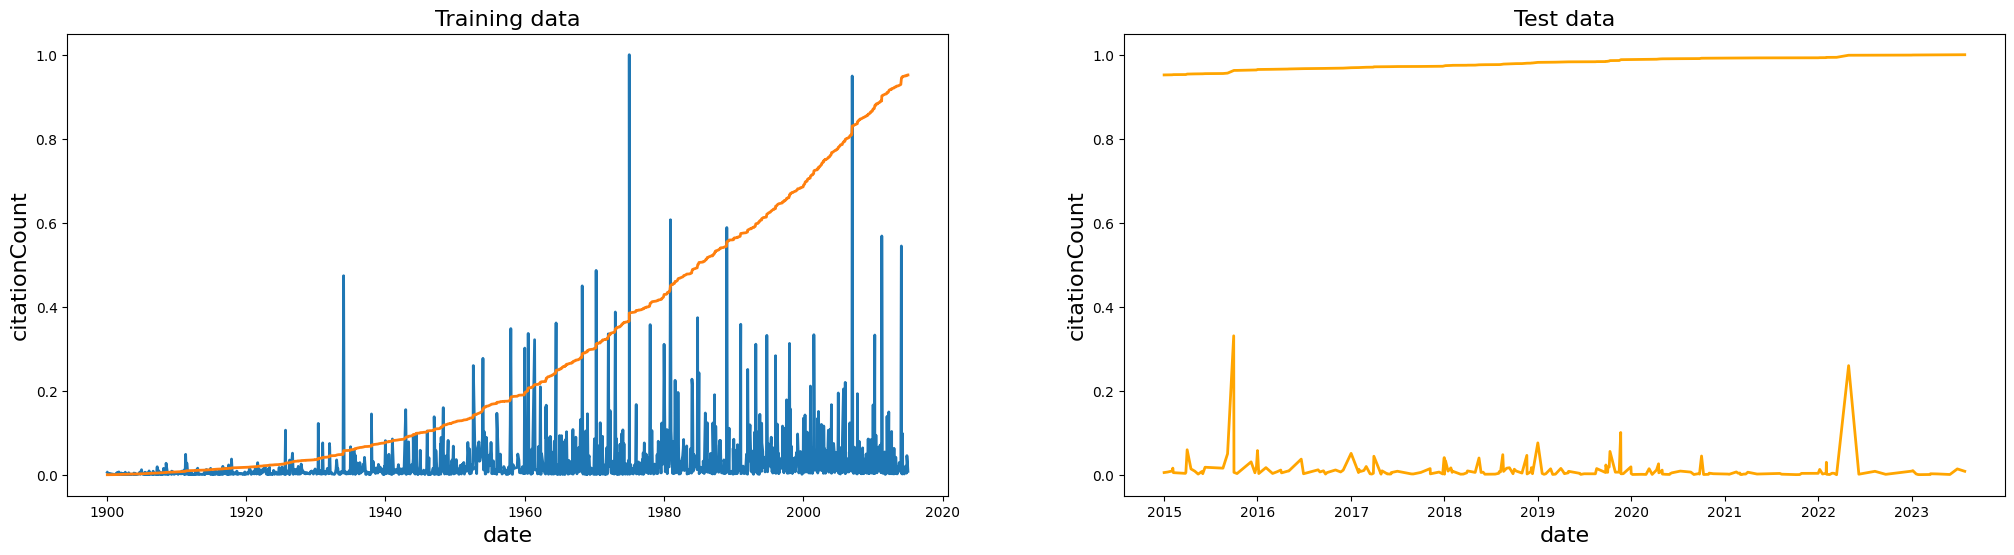

In [314]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
ax1.plot(train_data.publicationDate, train_data['citationCount'], lw=2)
ax1.plot(train_data.publicationDate, train_data['cummulative_citationCount'], lw=2)
ax1.set_xlabel("date", fontsize=16)
ax1.set_ylabel("citationCount", fontsize=16)
ax1.set_title("Training data", fontsize=16)
ax2.plot(test_data.publicationDate, test_data['citationCount'], c='orange', lw=2)
ax2.plot(test_data.publicationDate, test_data['cummulative_citationCount'], c='orange', lw=2)
ax2.set_xlabel("date", fontsize=16)
ax2.set_ylabel("citationCount", fontsize=16)
ax2.set_title("Test data", fontsize=16)

### LSTM neural network

In [315]:
X_train = train_data.publicationDate
y_train = train_data['citationCount']

X_test = test_data.publicationDate
y_test = test_data['citationCount']

n_features = 1

train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))


In [332]:

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

look_back = 20

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

neurons=64
model = Sequential()
model.add(LSTM(neurons, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(neurons,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(neurons))
model.add(Dropout(0.2))
                    
model.add(Dense(1))  # Modify the output layer as needed
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_generator, epochs=200,verbose=0)


test_predictions  = model.predict(test_generator)

# uncomment to undo the scaling
test_data['citationCount'] = scaler.inverse_transform(test_data[['citationCount']])
test_predictions = scaler.inverse_transform(test_predictions)



''' 
#GRID SEARCH

# Define the hyperparameters to search
param_grid = {
    'neurons': [4, 8, 16, 32],  # Adjust this list to include the number of neurons you want to try
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(train_series, train_series)  # Use your training data here

# Print the best parameters and results
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best MSE: {-grid_result.best_score_}")
'''


36/36 [==============================] - 1s 2ms/step


' \n#GRID SEARCH\n\n# Define the hyperparameters to search\nparam_grid = {\n    \'neurons\': [4, 8, 16, 32],  # Adjust this list to include the number of neurons you want to try\n}\n\n# Perform grid search\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=\'neg_mean_squared_error\', cv=3)\ngrid_result = grid.fit(train_series, train_series)  # Use your training data here\n\n# Print the best parameters and results\nprint(f"Best Parameters: {grid_result.best_params_}")\nprint(f"Best MSE: {-grid_result.best_score_}")\n'

Text(0.5, 1.0, 'IBEX35 Closing value')

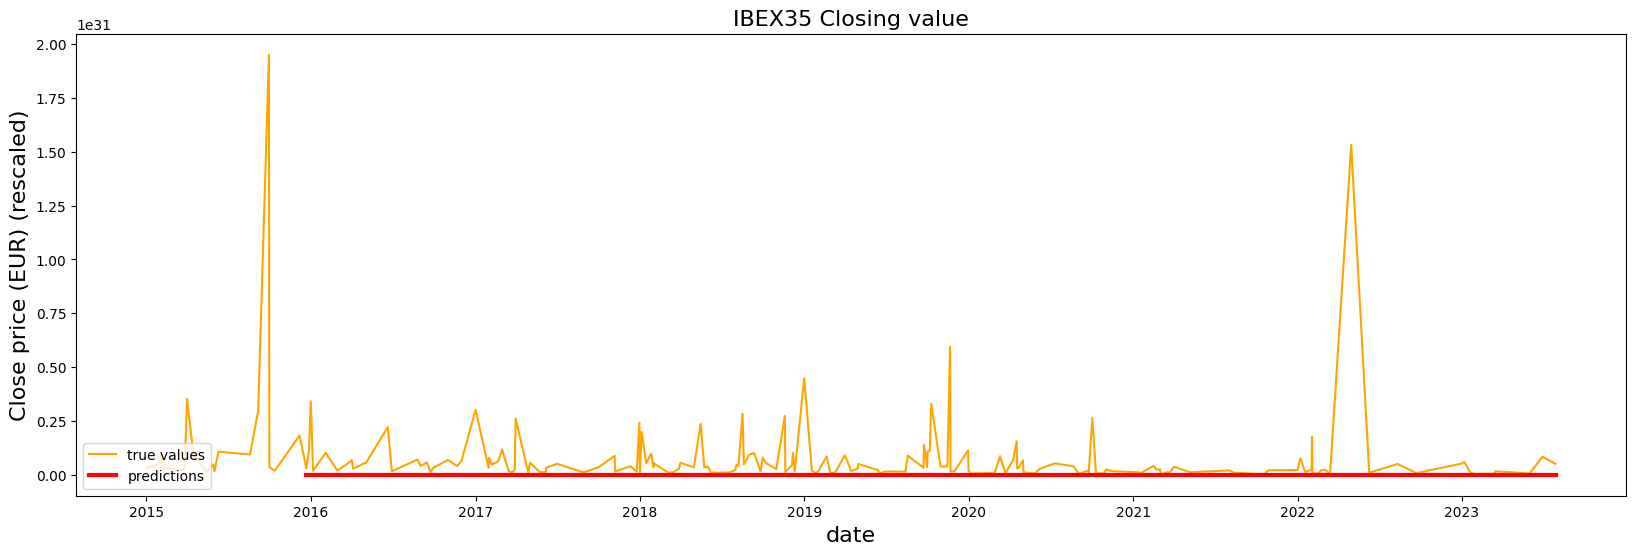

In [334]:
plt.figure(figsize=(20,6))
plt.plot(test_data.publicationDate, test_data['citationCount'], c='orange',label='true values')
plt.plot(X_test[20:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("IBEX35 Closing value", fontsize=16)

### Cummulative Citation Count


In [320]:
X_train = train_data.publicationDate
y_train = train_data['cummulative_citationCount']

X_test = test_data.publicationDate
y_test = test_data['cummulative_citationCount']

n_features = 1

train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))


In [321]:
from keras.layers import BatchNormalization
look_back = 20

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)



neurons=84
model = Sequential()
model.add(LSTM(neurons, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(neurons,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(neurons))
model.add(Dropout(0.2))


                    
model.add(Dense(1))  # Modify the output layer as needed
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_generator, epochs=200,verbose=0)

In [322]:
test_predictions  = model.predict(test_generator)
# uncomment to undo the scaling
test_data['cummulative_citationCount'] = scaler.inverse_transform(test_data[['cummulative_citationCount']])
train_data['cummulative_citationCount'] = scaler.inverse_transform(train_data[['cummulative_citationCount']])

test_predictions = scaler.inverse_transform(test_predictions)


18/18 [==============================] - 1s 3ms/step


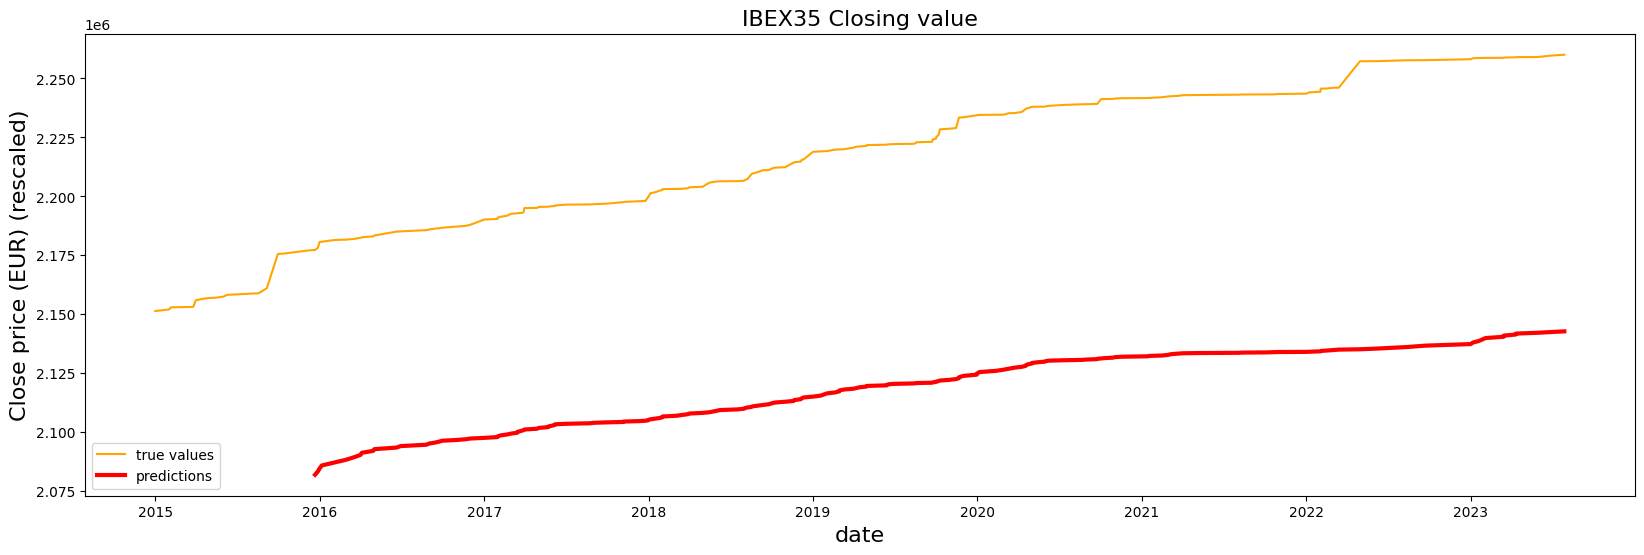

In [323]:
plt.figure(figsize=(20,6))
plt.plot(test_data.publicationDate, test_data['cummulative_citationCount'], c='orange',label='true values')
plt.plot(X_test[20:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("IBEX35 Closing value", fontsize=16);

Text(0.5, 1.0, 'Training data')

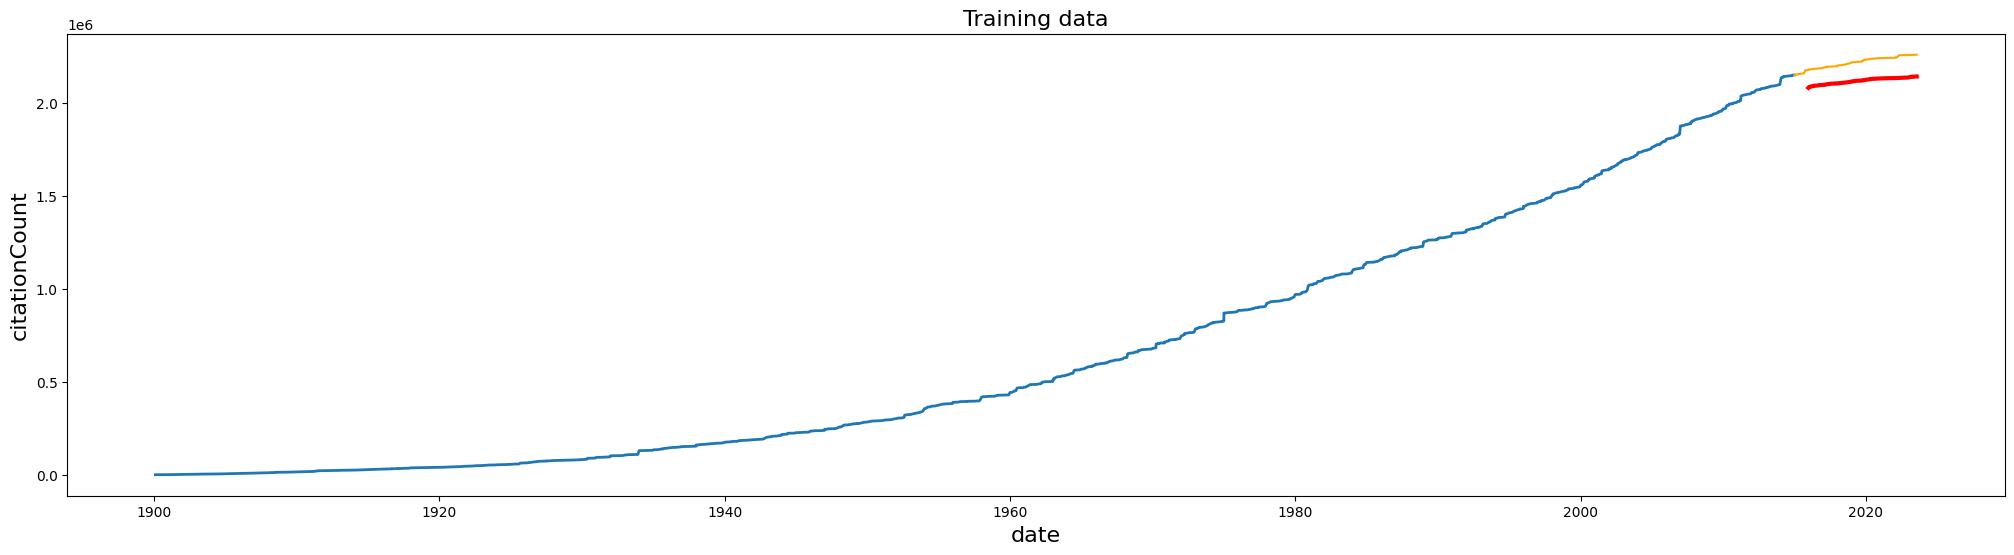

In [324]:
fig, (ax1) = plt.subplots(1, figsize=(25, 6))
ax1.plot(train_data.publicationDate, train_data['cummulative_citationCount'], lw=2)
ax1.plot(test_data.publicationDate, test_data['cummulative_citationCount'], c='orange',label='true values')
ax1.plot(X_test[20:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')

ax1.set_xlabel("date", fontsize=16)
ax1.set_ylabel("citationCount", fontsize=16)
ax1.set_title("Training data", fontsize=16)


In [325]:
test_data

,publicationDate,referenceCount,citationCount,influentialCitationCount,topic_code,x_vector,y_vector,z_vector,cummulative_citationCount
0,2015-01-01,254,12414.450883,8,0,9.560430,9.497765,16.784879,2151390.0
1,2015-01-15,77,15247.693761,8,0,5.695261,4.218186,8.143107,2151679.0
2,2015-02-01,97,20704.309675,5,0,4.300642,4.471894,8.850463,2152072.0
3,2015-02-04,163,36182.210583,31,0,11.060249,8.372221,15.803460,2152760.0
4,2015-02-06,31,11889.776276,20,0,4.106937,4.570239,8.898826,2152985.0
5,2015-03-25,134,8059.651645,7,0,6.265434,4.059911,8.611590,2153137.0
6,2015-03-27,146,13253.930255,14,0,3.683928,3.206747,8.161913,2153388.0
7,2015-04-01,443,134978.439089,70,0,5.005841,4.847177,8.261859,2155959.0
8,2015-04-16,59,31879.878805,69,0,4.265124,5.379788,8.262882,2156565.0
9,2015-05-01,167,19759.895382,21,0,4.562879,5.284867,8.098251,2156940.0


### create new df

In [333]:
topic_labels_df.head(10)

,topic_labels,n_nb_topic_0,n_nb_distance_0,n_nb_topic_1,n_nb_distance_1,n_nb_topic_2,n_nb_distance_2,n_nb_topic_3,n_nb_distance_3,n_nb_topic_4,...,n_nb_topic_112,n_nb_distance_112,n_nb_topic_113,n_nb_distance_113,n_nb_topic_114,n_nb_distance_114,n_nb_topic_115,n_nb_distance_115,n_nb_topic_116,n_nb_distance_116
0,0_species_soil_plant_plants,0,0,67,2.016517,77,2.086345,4,2.453928,7,...,61,7.598980,39,7.697668,44,7.747544,69,7.777791,57,7.844189
1,1_coli_escherichia_escherichia coli_strains,1,0,94,0.861683,98,1.495111,49,1.562618,97,...,80,8.631868,72,8.633318,68,8.794184,17,8.801515,33,8.839814
2,2_chromatography_liquid_liquid chromatography_determination,2,0,77,0.806960,41,1.409208,67,1.479810,97,...,39,7.412360,57,7.435924,66,7.456084,69,7.604247,33,7.704082
3,3_political_politics_language_social,3,0,59,0.725362,5,1.325051,11,1.371638,51,...,44,7.984457,73,8.003182,24,8.007140,53,8.023838,45,8.081010
4,4_der_die_und_von,4,0,23,1.802350,55,1.841656,56,1.931493,51,...,69,7.786374,64,7.882692,44,7.916049,66,7.916175,57,8.006525
5,5_firms_economic_market_trade,5,0,33,1.161764,68,1.213245,3,1.325051,59,...,44,9.204874,24,9.308126,73,9.317680,53,9.325111,45,9.375408
6,6_cortex_motor_memory_visual,6,0,58,0.903380,108,1.022831,34,1.027044,110,...,15,7.257518,109,7.323257,27,7.483729,80,7.825686,17,7.989792
7,7_da_que_em_para,7,0,3,2.355537,0,2.485169,4,2.646734,51,...,39,8.627094,69,8.644713,64,8.866333,57,8.919234,44,9.010915
8,8_microfluidic_device_cell_flow,8,0,16,1.386199,87,2.032576,97,2.193777,2,...,42,7.842925,89,7.899822,5,7.964783,48,8.175475,33,8.464033
9,9_energy_molecules_molecular_calculations,9,0,65,0.822271,32,0.829202,95,0.931024,101,...,89,8.585097,61,8.616785,40,8.652285,69,8.714961,57,8.723689


In [ ]:
# looping over all topics in order to create new dataframe for citationCount prediction

topic_dataframes_list = []

for index in (range(len(topic_labels_df))):
#for index in (range(2)):

    grouped_by_all_topics = topified_vectorized_Science1900_2023.groupby('topic_code')
    temporary_topic_df = grouped_by_all_topics.get_group(index)

    # replace NAN Values in publicationDate with year values 
    temporary_topic_df['publicationDate'].fillna(temporary_topic_df['year'].apply(lambda x:x), inplace=True)
    #drop year column
    temporary_topic_df.drop('year', axis=1,inplace=True)


    temporary_topic_df= temporary_topic_df.groupby('publicationDate').sum('citationCount')
    temporary_topic_df['cummulative_citationCount'] = temporary_topic_df['citationCount'].cumsum()
    display(temporary_topic_df)
    topic_dataframes_list.append(temporary_topic_df)

In [373]:
citation_count_predictions_for_each_topic = []
scaler = MinMaxScaler(feature_range=(0, 1))

#for index in range(len(topic_dataframes_list)):
for index in range(3):
    topic_dataframes_list[index]['citationCount'] = scaler.fit_transform(topic_dataframes_list[index][['citationCount']])

    #train / test split
    train_data = topic_dataframes_list[index].query('publicationDate <  "2015-01-01"').reset_index(drop = False) 
    test_data  = topic_dataframes_list[index].query('publicationDate >= "2015-01-01"').reset_index(drop = False)

    X_train = train_data.publicationDate
    y_train = train_data['citationCount']   # implement cummulative_citationCount ?
    X_test = test_data.publicationDate
    y_test = test_data['citationCount']

    n_features = 1

    train_series = y_train.values.reshape((len(y_train), n_features))
    test_series  = y_test.values.reshape((len(y_test), n_features))


    look_back = 20

    train_generator = TimeseriesGenerator(train_series, train_series,
                                        length        = look_back, 
                                        sampling_rate = 1,
                                        stride        = 1,
                                        batch_size    = 10)

    test_generator = TimeseriesGenerator(test_series, test_series,
                                        length        = look_back, 
                                        sampling_rate = 1,
                                        stride        = 1,
                                        batch_size    = 10)

    neurons=4
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(look_back, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(neurons,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(neurons))
    model.add(Dropout(0.2))
                        
    model.add(Dense(1))  # Modify the output layer as needed
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_generator, epochs=20,verbose=0)

    test_predictions  = model.predict(test_generator)

    # uncomment to undo the scaling
    test_data['citationCount'] = scaler.inverse_transform(test_data[['citationCount']])
    test_predictions = scaler.inverse_transform(test_predictions)

    citation_count_predictions_for_each_topic.append([index, test_predictions])



4/4 [==============================] - 0s 3ms/step


In [374]:
cummulative_citation_count_predictions_for_each_topic = []
scaler = MinMaxScaler(feature_range=(0, 1))

#for index in range(len(topic_dataframes_list)):
for index in range(3):
    topic_dataframes_list[index]['cummulative_citationCount'] = scaler.fit_transform(topic_dataframes_list[index][['cummulative_citationCount']])

    #train / test split
    train_data = topic_dataframes_list[index].query('publicationDate <  "2015-01-01"').reset_index(drop = False) 
    test_data  = topic_dataframes_list[index].query('publicationDate >= "2015-01-01"').reset_index(drop = False)

    X_train = train_data.publicationDate
    y_train = train_data['cummulative_citationCount']   # implement cummulative_cummulative_citationCount ?
    X_test = test_data.publicationDate
    y_test = test_data['cummulative_citationCount']

    n_features = 1

    train_series = y_train.values.reshape((len(y_train), n_features))
    test_series  = y_test.values.reshape((len(y_test), n_features))


    look_back = 20

    train_generator = TimeseriesGenerator(train_series, train_series,
                                        length        = look_back, 
                                        sampling_rate = 1,
                                        stride        = 1,
                                        batch_size    = 10)

    test_generator = TimeseriesGenerator(test_series, test_series,
                                        length        = look_back, 
                                        sampling_rate = 1,
                                        stride        = 1,
                                        batch_size    = 10)

    neurons=4
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(look_back, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(neurons,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(neurons))
    model.add(Dropout(0.2))
                        
    model.add(Dense(1))  # Modify the output layer as needed
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_generator, epochs=20,verbose=0)

    test_predictions  = model.predict(test_generator)

    # uncomment to undo the scaling
    test_data['cummulative_citationCount'] = scaler.inverse_transform(test_data[['cummulative_citationCount']])
    test_predictions = scaler.inverse_transform(test_predictions)

    citation_count_predictions_for_each_topic.append([index, test_predictions])



4/4 [==============================] - 0s 4ms/step
